# Statistical and systematic uncertainties in fitting

Originally developed by William Irvine for PHYS 211 (January 2016)

## Introduction 

This program generates mock data sets given a model, with adjustable statistical and systematic uncertainties.

The purpose is to both quantitiatively and graphically represent the effects of statistical and systematic uncertainties on a linear fit to data. This is accomplished by generating a pseudodata dataset that is assigned both statistical and systematic uncertainties. 

## Preliminaries

Import the appropriate libraries and define a several helper methods, such as creating linear functions, pseudodata, and figures.

* `linear(p, x)`
* `linear_residual(p, x, y, dy)`
* `gauss(x, mu, sigma, A)`
* `gdist(N=100, mean=0, sigma=5)`
* `mockdata(x, sigma, func)`

In [1]:
import numpy as np
from scipy import loadtxt, optimize
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

### Simple linear function

This function will create a line given is parameters (slope and y-intercept) and an array of values `x` at which to evaluate the function.

In [2]:
# simple linear function
def linear(p, x):
    """
    Creates a simple linear function
    
    Parameters
    ----------
    p: array of parameters
      p[0] is the y-intercept
      p[1] is the slope
    
    x: array of x-values at which to 
       evaluate the linear function
    """
    
    return p[0] + p[1]*x

### Residual linear function

Computes the residuals for a simple linear function. Residuals are the differences between what is plotted in your scatter plot at a specific point, and what the linear equation predicts "should be plotted" at this specific point. That is, it's the difference between the "observed" and the "expected" values of a function evaluated at specific position.

In [3]:
# residual of a linear function 
def linear_residual(p, x, y, dy):
    """
    Computes the residuals for a simple linear function
    
    Parameters
    ----------
    p: array of parameters
      p[0] is the y-intercept
      p[1] is the slope
    
    x: array of x-values at which to 
       evaluate the linear function
       
    y: array of observed y-values
    
    dy: uncertainties on the observed y-values
    """
    
    return (linear(p,x)-y)/dy

### Create a Gaussian function

Nothing special here, just to explicitly create a Gaussian for display purposes.

In [4]:
# gaussian function
def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

### Gaussian random variable

Here we want to draw values from a Gaussian distributions. I used the `numpy.random.randn(d0, d1, ..., dn)` function:

>Return a sample (or samples) from the “standard normal” distribution. If positive, int_like or int-convertible arguments are provided, `randn` generates an array of shape `(d0, d1, ..., dn)`, filled with random floats sampled from a univariate “normal” (Gaussian) distribution of mean 0 and variance 1


In [5]:
# values drawn from gaussian distribution
def gdist(N=100, mean=0, sigma=5):
    return sigma*np.random.randn(N)+mean

### Generate `pseudodata`

Here we want to draw values from a Gaussian distribution centered on some value with some standard deviation.

The point is that we want to simulate the fact that our measurements of physical processes are statistical in nature, and so even if there is a "true" value, even a perfect measurement will really represent a sampling of an underlying distribution of possible measurements with some uncertainty. 

The `sigma` of this Gaussian will determine the uncertainties on the points we "measure" later.

In [7]:
# generate a mock dataset: function func evaluated at x-values x, with standard deviations sigma 
def mockdata(x, sigma, func):
    """
    Generates a pseudodata dataset of y-values distributed according 
    to a Gaussian distribution, with a mean value given by evaluating 
    the function `func` at the corresponding x-values, `x`, and with
    standard deviations `sigma`.
    
    Parameters
    ----------
    x: array of x-values at which to 
       evaluate the function provided
      
    sigma: value or array of values of 
           uncertainties on y-values at 
           each x-value specified
       
    func: function that gives the y-value 
          on which to center a Gaussian 
          distribution of possible y-values
    """
    
    # if standard deviation is a single number - that is assigned to all points
    if np.size(sigma)==1:
        sigma = sigma*np.ones_like(x)
    
    # Initialize an array to hold the generated distribution of y-values 
    # based on a probability distribution function func
    yy=[]
    
    # otherwise each point can have a separate sigma
    err=sigma
    
    # loop over all of the x-values and generate a Gaussian distribution 
    # of y-values given by the `gdist` function with standard deviations
    # given by the uncertainty in the y-values specified by `sigma`
    for xi, si in zip(x,sigma):
        yy.append( gdist(N=1, mean=func(xi), sigma=si)[0] )
    
    yy = np.array(yy)
    
    # Return the array of y-values distributed according to a Gaussian 
    # distribution, with a mean value given by evaluating the function
    # `func` at the corresponding x-values
    return yy, err

## Setup variables and parameters

Here is where we will set some variables and parameters for running our test data.

In particular, we will set:
* systematic uncertainties that (might) exist
* "true" errors on our underlying model
* estimated errors
* slope and `y`-intercept of our "true" model (i.e. the model parameters)

### `x` values

I just separate this out in order to have a clear and single place where the `x` values at which we will evaluate our function are defined. 

In [8]:
# x coordinates that specify the measurements
xvalues = np.array([0,2,3,4,5,15,30])

### Systematic uncertainties

Define any systematic uncertainties here. We will use these to update our "measurements" later. For a first iteration, you can set the values to zero using a multplier.

In [49]:
# Systematic uncertainties for each measurement point
systs = 1.0*np.array([1,3,-2,7,-3,2,-5])

### "True" errors

Set the "true" statistical uncertainties that define the underlying distributions from which our measurements are drawn.

In [45]:
# Underlying ("true") standard deviations of values of the measurements at each point `x`
# These are what we will use to generate the distributions of possible measurements
true_error = np.array([2,2,2,3,3,3,3.5])

### "Estimated" errors

These errors define the our estimates of the true errors. You can set them equal to one another, or not! Change this and see what happens to your distribution of chi-squared values.

In [46]:
# Estimated errors (could be the same as the true errors, or not)
estimated_error = 2.0*true_error

### True model

These are the parameters of the "true" model (i.e. the slope and y-intercept of the line). 

In [12]:
# Specify the "true" model. That is, we define the y-intercept (p0[0]) and slope (p0[1]) of our linear system 
p0 = [2,3.3]

### Function for generating mock data

We will use this for building our lines

In [13]:
# Create a lambda function for handing to the mockdata
func = lambda x: linear(p0, x)
func_residual = linear_residual

## Plotting helpers

These are just a few functions that will help us with plotting.

### Plot true model (our line)

Here we build a function that will plot the true model, i.e. our line. 

Having this in a single function will help us significantly later on.

In [14]:
def plottruemodel(xarray, ax):
    # plot the perfect line
    ax.plot(xarray, func(xarray), '-', color='gray', alpha=0.3, label = 'True model')
    
    return ax

### Make my figure

This function just builds the figure and axes of our plots. This is useful because we are going to make several different plots and I want them all to look the same ;-)

In [15]:
# Create the figure and its axes that we'll use throughout the plotting
def make_my_figure(xmax=35, ymax=120): 
    
    fig = plt.figure()

    fig.patch.set_facecolor('w')

    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75]) 
    ax.set_title('Some Sample Data with Error Bars')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim([0,xmax])
    ax.set_ylim([0,ymax])
    
    return fig, ax

### `X` array

This gives us an array of x-values to plot the line. We will use this throughout the examples below

In [16]:
# This gives us an array of x-values to plot the line
xarray = np.arange(0,35)

## Run our toy simulation of "nature" (i.e. a straight line)

Now we need to get to work! 


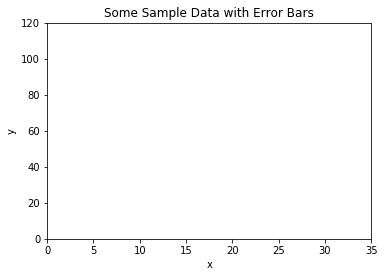

In [17]:
# Create figure and axes so that they can be reused
fig, ax = make_my_figure()

* Build the canvas for drawing
* Plot the true model (i.e. a perfect line given the model parameters)
* Plot the PDFs of the underlying data, which represent the distribution of which our measurements will sample

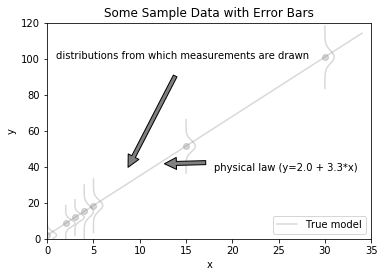

In [19]:
# Build the canvas again
fig, ax = make_my_figure()

# plot the perfect line
ax = plottruemodel(xarray, ax)

# Annotate the plot to indicate what it is that we've drawn
ax.annotate('physical law (y=%.1f + %.1f*x)' % (p0[0], p0[1]), 
            xy=(12, func(12)), xytext=(18, 38), 
            arrowprops=dict(facecolor='gray', shrink=0.11))

ax.annotate('distributions from which measurements are drawn', 
            xy=(8, func(8)+4), xytext=(1, 100), 
            arrowprops=dict(facecolor='gray', shrink=0.11))

# plot the pdfs of the underlying data
for xi,tei in zip(xvalues, true_error):
    yi = func(xi)
    yyy = np.arange(yi-5*tei,yi+5*tei,10*tei/100.)
    newxarray = xi+gauss(yyy,yi,tei,1)
    ax.plot(newxarray,yyy,'-',color='gray',alpha=0.3)
    ax.plot(xi,yi,'o',color='gray',alpha=0.3, label = '')

    
# Position the legend
ax.legend(loc=4)

Same as above but
* Add any systematic errors by shifting the underlying distributions away from the true model

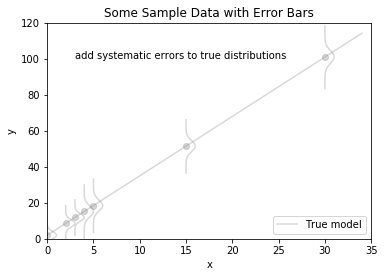

In [20]:
# Build the canvas again
fig, ax = make_my_figure()

# plot the true model
ax = plottruemodel(xarray, ax)   

# Annotate the plot
ax.text(3,100,'add systematic errors to true distributions')

# plot the pdfs of the underlying data
for xi,tei,ssi in zip(xvalues, true_error, systs):
    yo = func(xi)
    yi = func(xi) + ssi
    yyy = np.arange(yi-5*tei,yi+5*tei,10*tei/100.)
    xxx = xi+gauss(yyy,yi,tei,1)
    ax.plot(xxx,yyy,'-',color='gray',alpha=0.3)
    ax.plot(xi,yi,'o',color='gray',alpha=0.3, label='')
    ax.annotate('', xy=(xi,yi), xytext=(xi, yo), 
    arrowprops=dict(facecolor='green',arrowstyle="->")) 
    

# Position the legend
ax.legend(loc=4)

Same as above but
* Sample from the true underlying distributions by using the `mockdata` function
* If there are systematic uncertainties, include them in the `yvalues_syst` variable

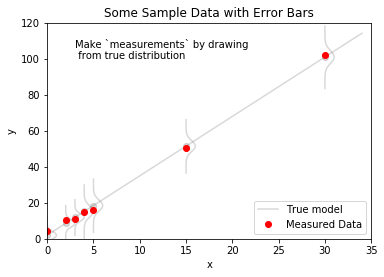

In [22]:
# Build the canvas again
fig, ax = make_my_figure()

# plot the true model
ax = plottruemodel(xarray, ax)   

# Generate some pseudodata according to the true underlying PDF
yvalues, ee     = mockdata(xvalues, true_error, func)
yvalues_nominal = yvalues
yvalues_syst    = yvalues + systs

ax.text(3,100,'Make `measurements` by drawing\n from true distribution')
    
# plot the pdfs of the underlying data
for xi,tei,ssi in zip(xvalues, true_error, systs):
    yo = func(xi)
    yi = func(xi) + ssi
    yyy = np.arange(yi-5*tei,yi+5*tei,10*tei/100.)
    xxx = xi+gauss(yyy,yi,tei,1)
    ax.plot(xxx,yyy,'-',color='gray',alpha=0.3)
    ax.plot(xi,yi,'o',color='gray',alpha=0.3, label='')

l2 = ax.plot(xvalues, yvalues_syst, 'ro', label = 'Measured Data')
    
# Position the legend
ax.legend(loc=4)

Now
* add uncertainties to our measurements using the `sigma` from the model

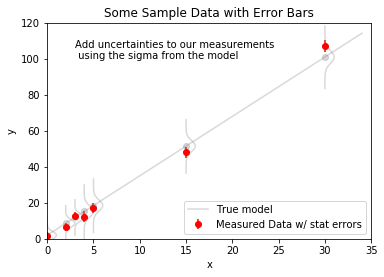

In [23]:
# Build the canvas again
fig, ax = make_my_figure()

# plot the true model
ax = plottruemodel(xarray, ax)   

# Generate some pseudodata according to the true underlying PDF
yvalues, ee     = mockdata(xvalues, true_error, func)
yvalues_nominal = yvalues
yvalues_syst    = yvalues + systs

ax.text(3,100,'Add uncertainties to our measurements\n using the sigma from the model')
    
# plot the pdfs of the underlying data
for xi,tei,ssi in zip(xvalues, true_error, systs):
    yo = func(xi)
    yi = func(xi) + ssi
    yyy = np.arange(yi-5*tei,yi+5*tei,10*tei/100.)
    xxx = xi+gauss(yyy,yi,tei,1)
    ax.plot(xxx,yyy,'-',color='gray',alpha=0.3)
    ax.plot(xi,yi,'o',color='gray',alpha=0.3)

l2 = ax.errorbar(xvalues, yvalues_syst, ee, fmt='ro', label = 'Measured Data w/ stat errors')
 
ax.legend(loc=4)    
    
#display.clear_output(wait=True)
#display.display(fig)

* Perform a fit to our measurements using the `optimize.leastsq` function
   * See: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html
   * Minimize the sum of squares of a set of equations
   * `leastsq` is a wrapper around MINPACK’s `lmdif` and `lmder` algorithms.
      * `cov_x` is a Jacobian approximation to the Hessian of the least squares objective function. 

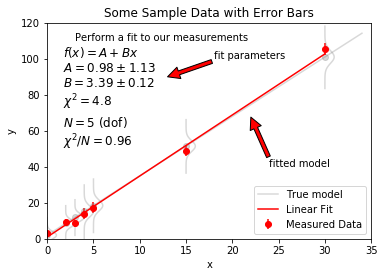

In [25]:
# Build the canvas again
fig, ax = make_my_figure()

# plot the true model
ax = plottruemodel(xarray, ax)   

# Generate some pseudodata according to the true underlying PDF
yvalues, ee     = mockdata(xvalues, true_error, func)
yvalues_nominal = yvalues
yvalues_syst    = yvalues + systs

ax.text(3, 110, 'Perform a fit to our measurements')

# Perform the fit to our pseudodata
fitparams, cov, info, mesg, success = optimize.leastsq(func_residual, p0, args=(xvalues, yvalues_syst, estimated_error), full_output=1)
chisq = sum(info["fvec"]*info["fvec"])
dof   = len(xvalues)-len(fitparams)

# Put the fit errors 
fitparamerr = []
for i in range(len(fitparams)):
    fitparamerr.append(np.sqrt(cov[i,i]))

# text for reporting fit paramaters
textfit = '$f(x) = A + Bx$ \n' \
          '$A = %.2f \pm %.2f$ \n' \
          '$B = %.2f \pm %.2f$ \n' \
          '$\chi^2= %.1f$ \n' \
          '$N = %i$ (dof) \n' \
          '$\chi^2/N = % .2f$' \
             % (fitparams[0], fitparamerr[0], fitparams[1], fitparamerr[1],
                chisq, dof, chisq/dof)

# plot the pdfs of the underlying data
for xi,tei,ssi in zip(xvalues, true_error, systs):
    yi = func(xi) + ssi
    yyy = np.arange(yi-5*tei,yi+5*tei,10*tei/100.)
    xxx = xi+gauss(yyy,yi,tei,1)
    ax.plot(xxx,yyy,'-',color='gray',alpha=0.3)
    ax.plot(xi,yi,'o',color='gray',alpha=0.3)


#plot fitted line
l3 = ax.plot(xvalues, linear(fitparams, xvalues), 'r-', label = 'Linear Fit')

ax.annotate('fitted model', xy=(22, func(22)-7), xytext=(24, 40), 
        arrowprops=dict(facecolor='red', shrink=0.))

ax.annotate('fit parameters', xy=(13,90), xytext=(18, 100), 
        arrowprops=dict(facecolor='red', shrink=0.))

ax.text(0.05, .90, textfit, transform=ax.transAxes, fontsize=12, verticalalignment='top')

# Now let's plot the data and the fit at the same time
#l1 = ax.errorbar(xvalues, yy0, ee, fmt='ko', label = 'Unbiased Data',alpha=0.3)
l2 = ax.errorbar(xvalues, yvalues_syst, estimated_error, fmt='ro', label = 'Measured Data')

ax.legend(loc=4)   

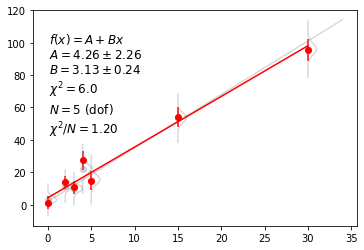

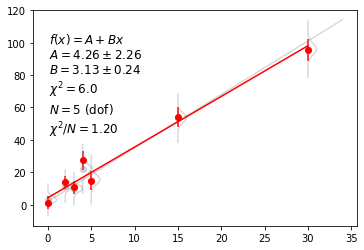

In [50]:
* Do the same as above, but many times!

In [ ]:
# Build the canvas again
fig, ax = make_my_figure()

# initialize array for collecting results of fits
results=[]

# generate 200 different fits
for rr in 1+np.arange(100):

    plt.cla()
    
    # plot the true model
    ax = plottruemodel(xarray, ax)   

    # Generate some pseudodata according to the true underlying PDF
    yvalues, ee     = mockdata(xvalues, true_error, func)
    yvalues_nominal = yvalues
    yvalues_syst    = yvalues + systs

    # Perform the fit to our pseudodata
    fitparams, cov, info, mesg, success = optimize.leastsq(func_residual, p0, args=(xvalues, yvalues_syst, estimated_error), full_output=1)
    chisq = sum(info["fvec"]*info["fvec"])
    dof   = len(xvalues)-len(fitparams)

    # Put the fit errors 
    fitparamerr = []
    for i in range(len(fitparams)):
        fitparamerr.append(np.sqrt(cov[i,i]))

    # text for reporting fit paramaters
    textfit = '$f(x) = A + Bx$ \n' \
              '$A = %.2f \pm %.2f$ \n' \
              '$B = %.2f \pm %.2f$ \n' \
              '$\chi^2= %.1f$ \n' \
              '$N = %i$ (dof) \n' \
              '$\chi^2/N = % .2f$' \
                 % (fitparams[0], fitparamerr[0], fitparams[1], fitparamerr[1],
                    chisq, dof, chisq/dof)

    # plot the pdfs of the underlying data
    for xi,tei,ssi in zip(xvalues, true_error, systs):
        yi = func(xi) + ssi
        yyy = np.arange(yi-5*tei,yi+5*tei,10*tei/100.)
        xxx = xi+gauss(yyy,yi,tei,1)
        ax.plot(xxx,yyy,'-',color='gray',alpha=0.3)
        ax.plot(xi,yi,'o',color='gray',alpha=0.3)

    # Now let's plot the data and the fit at the same time
    #l1 = ax.errorbar(xvalues, yy0, ee, fmt='ko', label = 'Unbiased Data',alpha=0.3)
    l2 = ax.errorbar(xvalues, yvalues_syst, estimated_error, fmt='ro', label = 'Measured Data')


    #plot fitted line
    l3 = ax.plot(xvalues, linear(fitparams, xvalues), 'r-', label = 'Linear Fit')

    #l4 = ax.errorbar(xx+0.1, yy, estimated_error, fmt='gx', label = 'Estimated Error')

    ax.text(0.05, .90, textfit, transform=ax.transAxes, fontsize=12,verticalalignment='top')

    display.clear_output(wait=True)
    display.display(fig)

    results.append([chisq/dof, fitparams[0], fitparams[1]])

Text(0, 0.5, 'Relative frequency')

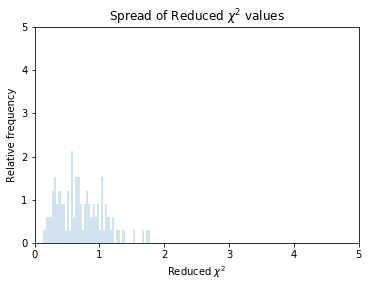

In [53]:
# Build the canvas again
fig, ax = make_my_figure(5,5)

results = np.array(results)


# Histogram the chi-square values
ax.hist(results[:,0], bins=int(np.size(results[:,0])/2), alpha=0.2, density=True)

ax.set_title('Spread of Reduced $\chi^2$ values')
ax.set_xlabel('Reduced $\chi^2$')
ax.set_ylabel('Relative frequency')


Text(0, 0.5, 'Relative frequency')

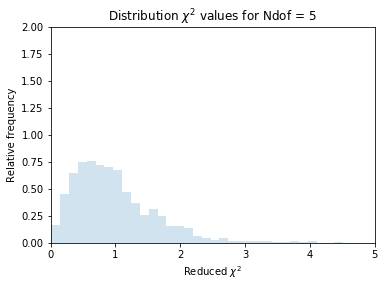

In [35]:
# Build the canvas again
fig, ax = make_my_figure(5,2)

# Histogram the chi-square values
ax.hist(np.random.chisquare(dof,1000)/dof, bins=int(np.size(results[:,0])/30), alpha=0.2, density=True)

ax.set_title('Distribution $\chi^2$ values for Ndof = %d' % dof)
ax.set_xlabel('Reduced $\chi^2$')
ax.set_ylabel('Relative frequency')


Text(0, 0.5, 'Relative frequency')

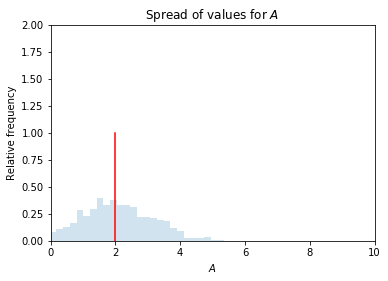

In [36]:
# Build the canvas again
fig, ax = make_my_figure(10,2)

# Histogram the y-intercepts
ax.hist(results[:,1], bins=int(np.size(results[:,0])/2), alpha=0.2, density=True)

ax.plot([p0[0],p0[0]],[0,1],'-r')

ax.set_title('Spread of values for $A$')
ax.set_xlabel('$A$')
ax.set_ylabel('Relative frequency')

Text(0, 0.5, 'Relative frequency')

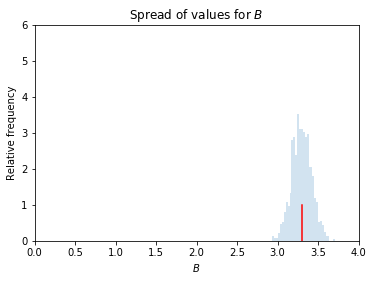

In [38]:
# Build the canvas again
fig, ax = make_my_figure(4,6)

# Histogram the slopes
ax.hist(results[:,2], bins=int(np.size(results[:,0])/30), alpha=0.2, density=True)

ax.plot([p0[1],p0[1]],[0,1],'-r')

ax.set_title('Spread of values for $B$')
ax.set_xlabel('$B$')
ax.set_ylabel('Relative frequency')